<a href="https://colab.research.google.com/github/Rexosaury/COMSYS-Hackathon-5-2025/blob/main/Gender_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =======================
# 1. Mount Google Drive
# =======================
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# =======================
# 2. Imports
# =======================
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
# =======================
# 3. Setup Paths
# =======================
import pathlib

# Change this to your dataset path
base_dataset_dir = '/content/drive/MyDrive/Comys_Hackathon5/Task_A/train'

# New directory for split data
base_split_dir = "/content/gender_split_data"
train_dir = os.path.join(base_split_dir, "train")
val_dir = os.path.join(base_split_dir, "val")

# Remove if previously exists
if os.path.exists(base_split_dir):
    shutil.rmtree(base_split_dir)

# Create train/val folders
for split in ["train", "val"]:
    for cls in ["female", "male"]:
        os.makedirs(os.path.join(base_split_dir, split, cls))


In [ ]:
# =======================
# 4. Split Dataset 70-30
# =======================
def split_data(source_dir, train_dest, val_dest, split_ratio=0.7):
    images = os.listdir(source_dir)
    images = [img for img in images if img.lower().endswith(('.jpg', '.png', '.jpeg'))]
    random.shuffle(images)

    split_idx = int(len(images) * split_ratio)
    train_imgs = images[:split_idx]
    val_imgs = images[split_idx:]

    for img in train_imgs:
        shutil.copy(os.path.join(source_dir, img), os.path.join(train_dest, img))
    for img in val_imgs:
        shutil.copy(os.path.join(source_dir, img), os.path.join(val_dest, img))

split_data(os.path.join(base_dataset_dir, 'male'), os.path.join(train_dir, 'male'), os.path.join(val_dir, 'male'))
split_data(os.path.join(base_dataset_dir, 'female'), os.path.join(train_dir, 'female'), os.path.join(val_dir, 'female'))


In [ ]:
# =======================
# 5. Image Generators
# =======================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=IMG_SIZE,
                                                batch_size=BATCH_SIZE,
                                                class_mode='binary')


Found 1346 images belonging to 2 classes.
Found 578 images belonging to 2 classes.


In [ ]:
# =======================
# 6. Handle Class Imbalance
# =======================
labels = train_generator.classes  # 0 for female, 1 for male
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(2.4472727272727273), 1: np.float64(0.6283846872082166)}


In [ ]:
# =======================
# 7. Build Model (MobileNetV2)
# =======================
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False  # Freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# =======================
# 8. Train Model
# =======================
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,
                    class_weight=class_weights)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.6292 - loss: 0.6745 - val_accuracy: 0.8789 - val_loss: 0.2945
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8444 - loss: 0.3726 - val_accuracy: 0.8841 - val_loss: 0.2839
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8692 - loss: 0.3107 - val_accuracy: 0.8824 - val_loss: 0.2885
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8634 - loss: 0.2851 - val_accuracy: 0.8789 - val_loss: 0.2885
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.8804 - loss: 0.2890 - val_accuracy: 0.8945 - val_loss: 0.2840
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8825 - loss: 0.2659 - val_accuracy: 0.9014 - val_loss: 0.2659
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.9004 - loss: 0.2552 - val_accuracy: 0.9083 - val_loss: 0.2425
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8940 - loss: 0.2384 - val_accuracy: 0.9118 - val_lo

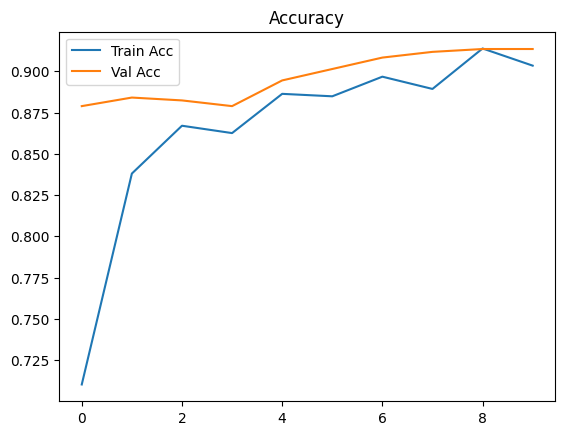

In [ ]:
# =======================
# 9. Plot Training Results
# =======================
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()


In [ ]:
# ================================
# SECTION 1: Save the Model (.keras)
# ================================
save_path = '/content/drive/MyDrive/comsys/models'
os.makedirs(save_path, exist_ok=True)

model_save_path = os.path.join(save_path, 'gender_classifier.keras')
model.save(model_save_path)

print(f"Model saved to: {model_save_path}")


Model saved to: /content/drive/MyDrive/comsys/models/gender_classifier.keras


Found 422 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step


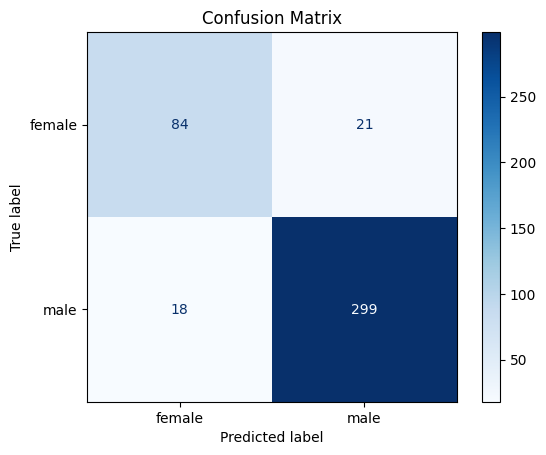

Classification Report:
               precision    recall  f1-score   support

      female       0.82      0.80      0.81       105
        male       0.93      0.94      0.94       317

    accuracy                           0.91       422
   macro avg       0.88      0.87      0.88       422
weighted avg       0.91      0.91      0.91       422



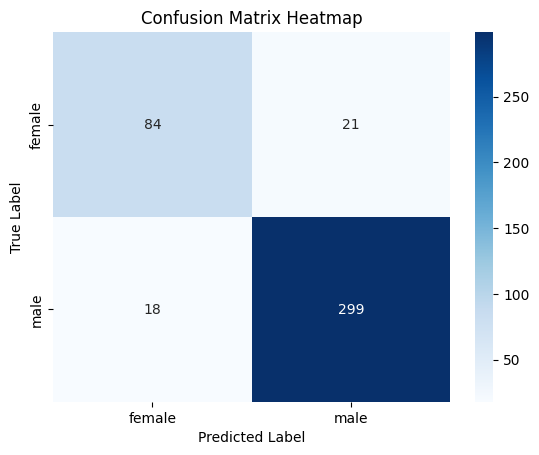

In [ ]:
# ================================
# SECTION 2: Load & Evaluate Model (Folder with male/female subfolders)
# ================================
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Load model
model = load_model('/content/drive/MyDrive/comsys/models/gender_classifier.keras')

# Path to validation/test images (structured with male/female subfolders)
test_data_dir = '/content/drive/MyDrive/Comys_Hackathon5/Task_A/val'

# Image generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Important for correct label mapping
)

# Predict
pred_probs = model.predict(test_generator)
pred_labels = (pred_probs > 0.5).astype("int").flatten()
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# ================================
# 📊 Evaluation & Visualization
# ================================

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(true_labels, pred_labels, target_names=class_names)
print("Classification Report:\n", report)

# Optional Heatmap
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix Heatmap")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()
